In [ ]:
import argparse
import random
import shutil
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split


In [ ]:
SEQUENCES = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]


def load_labels(file_path):
    labels = np.fromfile(file_path, dtype=np.uint32)
    semantic_labels = labels & 0xFFFF  # mask lower 16 bits
    instance_ids = labels >> 16  # upper 16 bits
    return semantic_labels, instance_ids


def parse_label(label, kitty_conf):
    return kitty_conf["learning_map"][label]


In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--dataset")
# parser.add_argument("--outfile")
# parser.add_argument("--fraction", type=float, default=0.02)
# parser.add_argument("--sem-kitty-conf", default="semantic-kitti.yaml")
# args = parser.parse_args()
# --outfile sem --dataset

outfile = Path("sem").stem
dataset = Path("/home/konstanty/STUDIA/masters_1_sem/rob3/data_odometry_velodyne")
with open("semantic-kitti.yaml", "r") as f:
    kitty_conf = yaml.load(f, yaml.Loader)
all_labels_dict = {}
for l in kitty_conf["learning_map_inv"]:
    all_labels_dict[l] = 0
print(all_labels_dict)
print(dataset)
print(outfile)
all_frames = 0
X = []
y = []
for seq in SEQUENCES:
    seqpath = "dataset/sequences/" + seq
    label_dir = dataset / seqpath / "labels"
    label_files = list(label_dir.iterdir())
    filtered_labels = []
    for file in label_files:
        X.append(file)
        all_frames += 1

        label, _ = load_labels(file)
        vals_unique = np.unique(label)
        # print(vals_unique)
        s = set()
        for v in vals_unique:
            s.add(parse_label(v, kitty_conf))
        y.append(list(s))
        for i in s:
            all_labels_dict[i] += 1
mlb = MultiLabelBinarizer()
labels_binary = mlb.fit_transform(y)

labels_df = pd.DataFrame(labels_binary, columns=mlb.classes_)


{-1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0}
/home/konstanty/STUDIA/masters_1_sem/rob3/data_odometry_velodyne
sem


In [8]:
labels_df2 = labels_df.sample(frac=1)

In [23]:
labels_df2.index.to_numpy().reshape(-1, 1).shape

(23201, 1)

In [22]:
np.arange(len(labels_df2)).reshape(-1, 1).shape

(23201, 1)

In [ ]:
import numpy as np

dummy_X = labels_df2.index.to_numpy().reshape(-1, 1)
y2 = labels_df2.values

X_train, y_train, X_test, y_test = iterative_train_test_split(
    dummy_X, y2, test_size=0.1
)

In [ ]:
# import numpy as np

# dummy_X = np.arange(len(labels_df)).reshape(-1, 1)  # dummy features
# y = labels_df.values

# X_train, y_train, X_test, y_test = iterative_train_test_split(
# 	dummy_X, y, test_size=0.1
# )

In [ ]:
np.round(np.sum(y_test, axis=0) / np.sum(y_test), 3)

array([0.082, 0.077, 0.019, 0.014, 0.009, 0.025, 0.024, 0.009, 0.003,
       0.082, 0.032, 0.078, 0.021, 0.074, 0.08 , 0.082, 0.074, 0.08 ,
       0.08 , 0.057])

In [ ]:
np.round(np.sum(y_train, axis=0) / np.sum(y_train), 3)

array([0.082, 0.077, 0.019, 0.013, 0.009, 0.026, 0.024, 0.008, 0.003,
       0.082, 0.032, 0.078, 0.022, 0.075, 0.08 , 0.082, 0.074, 0.08 ,
       0.08 , 0.057])

In [ ]:
np.round(np.sum(y, axis=0) / np.sum(y), 3)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23201,) + inhomogeneous part.

In [28]:
test_indices = X_test.flatten()

In [29]:
test_indices

array([15377,  1606,  7053, ...,  5253,  4781,  5533], shape=(2320,))

In [31]:
label_files = [X[i] for i in test_indices]

In [32]:
len(label_files), len(X)

(2320, 23201)

In [ ]:
with tempfile.TemporaryDirectory() as directory:
    for labelfile in label_files:
        # print(labelfile)
        seqname = labelfile.parents[1].name
        seqpath = "dataset/sequences/" + seqname
        bin_file = labelfile.stem + ".bin"
        # print(labelfile)
        res_velodyne = Path(directory) / seqpath / "velodyne"
        res_labels = Path(directory) / seqpath / "labels"
        if not res_velodyne.is_dir():
            res_velodyne.mkdir(parents=True)
            res_labels.mkdir(parents=True)

        # print(bin_file)
        shutil.copyfile(
            labelfile.parents[1] / "velodyne" / bin_file, res_velodyne / bin_file
        )
        shutil.copyfile(labelfile, res_labels / str(labelfile.stem + ".label"))
    print("done copying")
    print(directory)
    shutil.move(directory, ".")
    # shutil.make_archive("stratified", "zip", directory)

done copying
/tmp/tmp9vtga4uz


In [103]:
y

array([[1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 0]], shape=(23201, 20))

In [ ]:
new_y = []
for seq in SEQUENCES:
    seqpath = "dataset/sequences/" + seq
    label_dir = dataset / seqpath / "labels"
    label_files = list(label_dir.iterdir())
    filtered_labels = []
    for file in label_files:
        X.append(file)
        all_frames += 1

        label, _ = load_labels(file)
        vals_unique = np.unique(label)
        # print(vals_unique)
        s = set()
        for v in vals_unique:
            s.add(parse_label(v, kitty_conf))
        new_y.append(list(s))


In [128]:
import random

# Get class frequencies
class_counts = labels_df.sum()
rare_classes = class_counts[class_counts < len(labels_df) * 0.1].index
print(rare_classes)
# Get indices with rare classes
rare_indices = [
    i
    for i, labels in enumerate(new_y)
    if any(label in rare_classes for label in labels)
]

print(len(rare_indices))
rare_sample_size = int(len(new_y) * 0.1257)
common_sample_size = int(len(new_y) * 0.0001)

rare_sample = random.sample(rare_indices, rare_sample_size)
print(len(rare_sample))
common_sample = random.sample(
    list(set(range(len(new_y))) - set(rare_indices)), common_sample_size
)

sampled_indices = rare_sample + common_sample
sampled_data = [X[i] for i in sampled_indices]

Index([6, 7], dtype='int64')
2917
2916


In [129]:
len(sampled_indices)

2918

In [130]:
counts_post_sample = {}
for l in kitty_conf["learning_map_inv"]:
    counts_post_sample[l] = 0

In [131]:
for i in sampled_indices:
    for j in new_y[i]:
        counts_post_sample[j]+=1

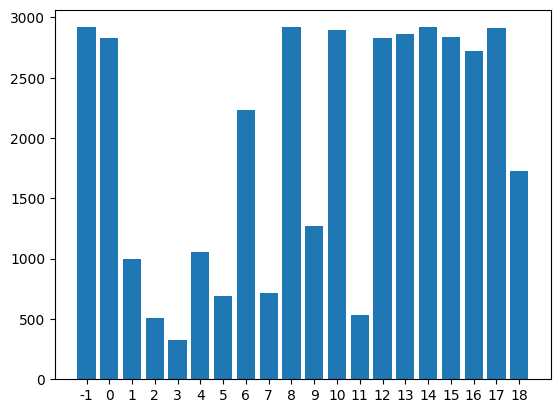

In [132]:
plt.bar(range(len(counts_post_sample)), list(counts_post_sample.values()), align='center')
plt.xticks(range(len(counts_post_sample)), list(counts_post_sample.keys()))
plt.show()

In [39]:
sampled_data = [X[i] for i in sampled_indices]
len(sampled_data)

2320

In [ ]:
with tempfile.TemporaryDirectory() as directory:
    for labelfile in sampled_data:
        # print(labelfile)
        seqname = labelfile.parents[1].name
        seqpath = "dataset/sequences/" + seqname
        bin_file = labelfile.stem + ".bin"
        # print(labelfile)
        res_velodyne = Path(directory) / seqpath / "velodyne"
        res_labels = Path(directory) / seqpath / "labels"
        if not res_velodyne.is_dir():
            res_velodyne.mkdir(parents=True)
            res_labels.mkdir(parents=True)

        # print(bin_file)
        shutil.copyfile(
            labelfile.parents[1] / "velodyne" / bin_file, res_velodyne / bin_file
        )
        shutil.copyfile(labelfile, res_labels / str(labelfile.stem + ".label"))
    print("done copying")
    print(directory)
    shutil.move(directory, ".")
    # shutil.make_archive("stratified", "zip", directory)

done copying
/tmp/tmpop1unhcv
